# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import pickle
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data 

Sample Data obtained from - https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [3]:
df = pd.read_csv('./data/pjm_kaggle/PJM_Load_hourly.csv')
df_raw = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32896 entries, 0 to 32895
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Datetime     32896 non-null  object 
 1   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.1+ KB


In [4]:
df.head()

,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


# Clean (Basic)

In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df = df[~df.index.duplicated(keep='first')]
print(df.index.is_monotonic_increasing)

True


In [6]:
df.rename(columns={'PJM_Load_MW': 'demand'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  32896 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [8]:
print(df.isnull().sum())

demand    0
dtype: int64


In [9]:
df = df.asfreq('H')

In [10]:
print(df.head())
print(df.tail())
print(df.index.is_monotonic_increasing)  

                      demand
Datetime                    
1998-04-01 01:00:00  22259.0
1998-04-01 02:00:00  21244.0
1998-04-01 03:00:00  20651.0
1998-04-01 04:00:00  20421.0
1998-04-01 05:00:00  20713.0
                      demand
Datetime                    
2001-12-31 20:00:00  36392.0
2001-12-31 21:00:00  35082.0
2001-12-31 22:00:00  33890.0
2001-12-31 23:00:00  32590.0
2002-01-01 00:00:00  31569.0
True


In [11]:
print(df.isnull().sum())

demand    8
dtype: int64


In [12]:
null_rows = df[df.isnull().any(axis=1)]
print(null_rows)

                     demand
Datetime                   
1998-04-05 03:00:00     NaN
1998-10-25 02:00:00     NaN
1999-04-04 03:00:00     NaN
1999-10-31 02:00:00     NaN
2000-04-02 03:00:00     NaN
2000-10-29 02:00:00     NaN
2001-04-01 03:00:00     NaN
2001-10-28 02:00:00     NaN


In [13]:
# df = df.dropna()
df['demand'] = df['demand'].fillna(df['demand'].mean())
print(df.isnull().sum())

demand    0
dtype: int64


# EDA

In [14]:
df.describe()

,demand
count,32904.000000
mean,29766.427408
std,5849.058757
min,17461.000000
25%,25473.750000
50%,29656.000000
75%,33071.250000
max,54030.000000


### Visualize Raw

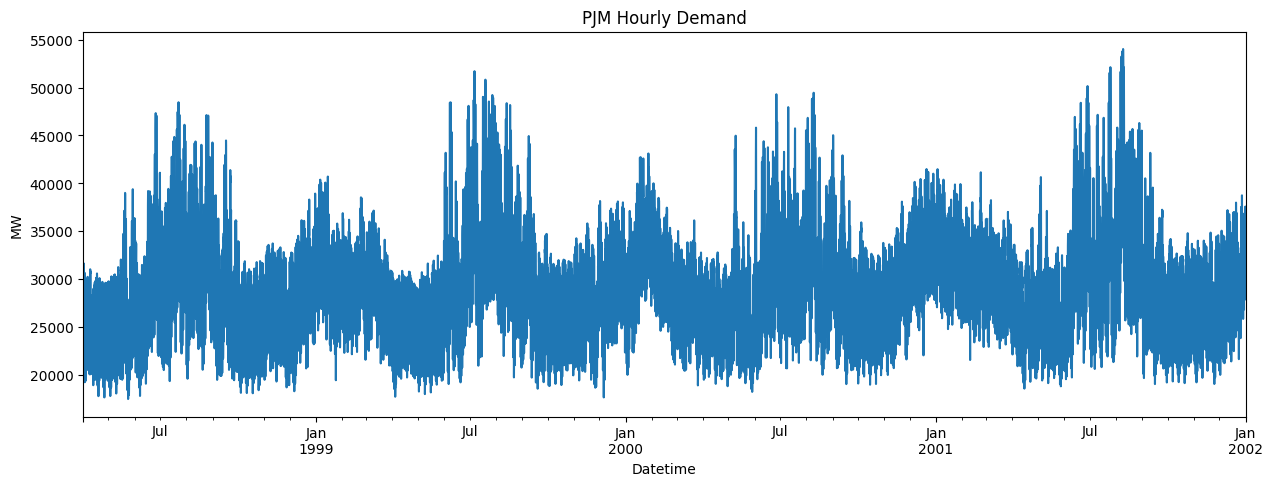

In [15]:
plt.figure(figsize=(15,5))
df['demand'].plot(title='PJM Hourly Demand', ylabel='MW')
plt.savefig('./data/output/pjm_demand.png', dpi=300)
plt.show()

## Correlation

### Daily

#### ACF

This will help us decide moving average window - it compares the selected demand with previous demand  
If the lag is 7 it'll compare kth demand value with k-7th demand value  
it uses pearson correlation in the background between the two series

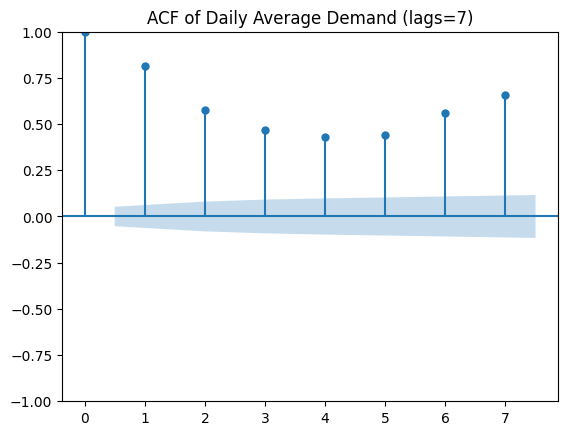

In [16]:
plot_acf(df['demand'].resample('D').mean().dropna(), lags=7)
plt.title('ACF of Daily Average Demand (lags=7)')
plt.savefig('./data/output/acf_lag7.png', dpi=300)
plt.show()

Conclusion - 1 is day before and it seems to have one of the strongest influence, so does a lag of 7 -> indicating weekly trend

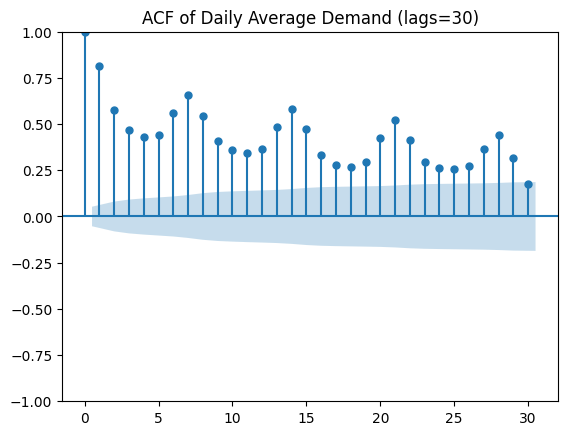

In [17]:
plot_acf(df['demand'].resample('D').mean().dropna(), lags=30)
plt.title('ACF of Daily Average Demand (lags=30)')
plt.savefig('./data/output/acf_lag30.png', dpi=300)
plt.show()

Once again emphasizing a weekly trend - slowly decaying as we move farther away

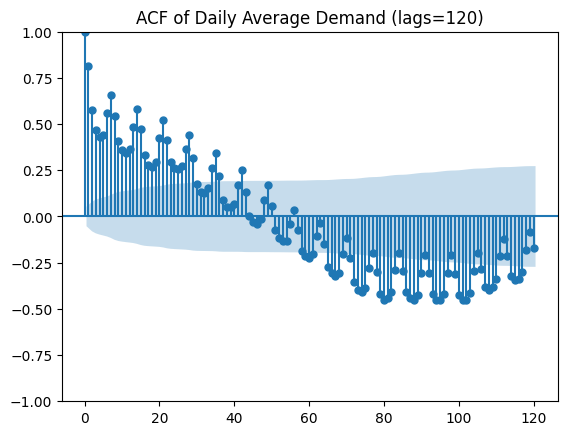

In [18]:
plot_acf(df['demand'].resample('D').mean().dropna(), lags=120)
plt.title('ACF of Daily Average Demand (lags=120)')
plt.savefig('./data/output/acf_lag120.png', dpi=300)
plt.show()

Conclusion - still carries the weekly trend but also indicates some periodic effects  
after 30 days there a decline in the correlation (also its within the band)  
from 60-90 days there's a peak again, and inverse peak at that - indicating values of today not only related to value of yesterday (1), one week ago (7), but also to values 2-3 months ago - lags about 90
this effect indicates seasonality every 3 months 

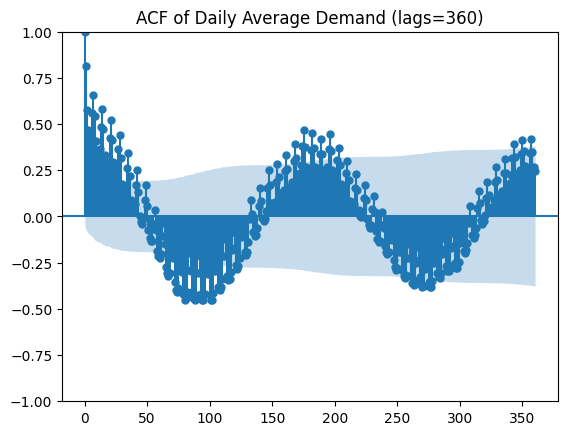

In [19]:
plot_acf(df['demand'].resample('D').mean().dropna(), lags=360)
plt.title('ACF of Daily Average Demand (lags=360)')
plt.savefig('./data/output/acf_lag360.png', dpi=300)
plt.show()

Conclusion - On a yearly scale, we see peaks at about 0, 180, 360 and troughs at about 90,270  
at 90 (about 3 months) we see the highest inverse effect probably because of season change  
at 180 (about 6months) we see peaks, indicating similar seasonal effect (like summer and winter causing more demand)  
at about 360 (1 year) we get back to the same season


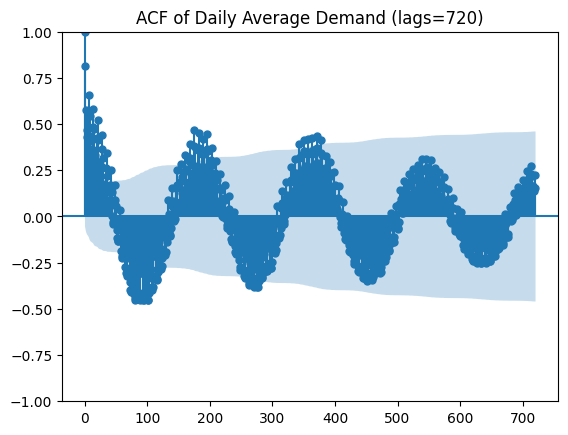

In [20]:
plot_acf(df['demand'].resample('D').mean().dropna(), lags=720)
plt.title('ACF of Daily Average Demand (lags=720)')
plt.savefig('./data/output/acf_lag720.png', dpi=300)
plt.show()

Conclusion - we also see an yearly periodicity

#### PACF

This will help us decide how many autoregressive steps to choose  

what it does is helps calculate the effect of a specific lag compared to all other lags  
so if we select a lag of 7, it'll compare whats the correlation of kth value with k-7th value, after removing the effect of k-1, k-2, k-3.. k-6

so here it basically uses something like a Yule-Walker equation in the background

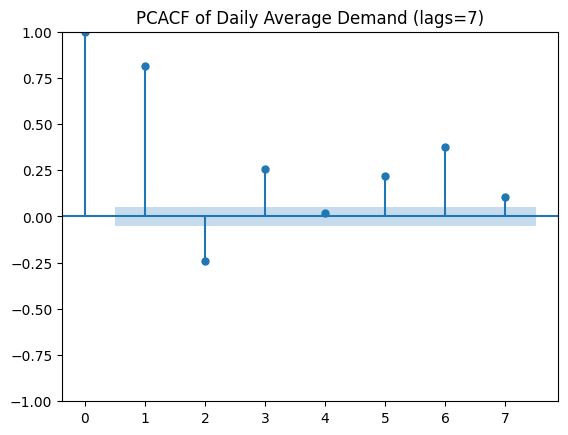

In [21]:
plot_pacf(df['demand'].resample('D').mean().dropna(), lags=7)
plt.title('PCACF of Daily Average Demand (lags=7)')
plt.savefig('./data/output/pacf_lag7.png', dpi=300)
plt.show()

Conclusion - lag 1 is quite strong than anything else lag 7 actually seems quite low impact by itself, it might carry cumulative power but none by itself

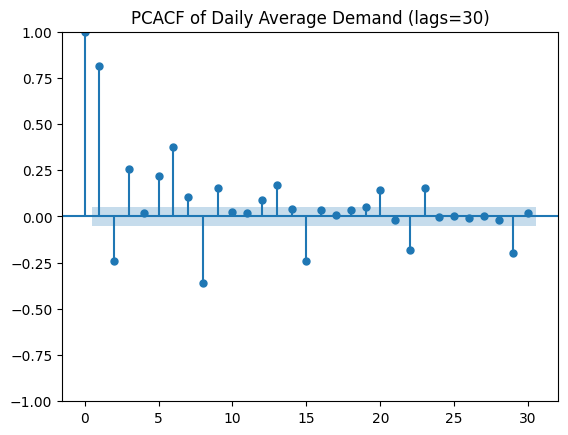

In [22]:
plot_pacf(df['demand'].resample('D').mean().dropna(), lags=30)
plt.title('PCACF of Daily Average Demand (lags=30)')
plt.savefig('./data/output/pacf_lag30.png', dpi=300)
plt.show()

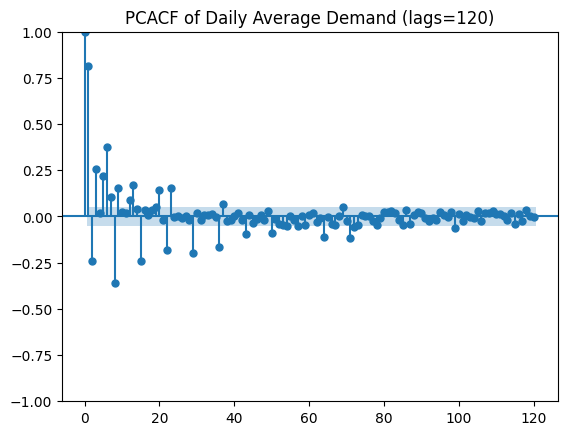

In [23]:
plot_pacf(df['demand'].resample('D').mean().dropna(), lags=120)
plt.title('PCACF of Daily Average Demand (lags=120)')
plt.savefig('./data/output/pacf_lag120.png', dpi=300)
plt.show()

Conclusion - No major spikes after early lags - so ar steps should be a select few in the beginning

In [24]:
# plot_pacf(df['demand'].resample('D').mean().dropna(), lags=360)
# plt.title('PCACF of Daily Average Demand (lags=360)')
# plt.savefig('./data/output/pacf_lag360.png', dpi=300)
# plt.show()

In [25]:
# plot_pacf(df['demand'].resample('D').mean().dropna(), lags=720)
# plt.title('PCACF of Daily Average Demand (lags=720)')
# plt.savefig('./data/output/pacf_lag720.png', dpi=300)
# plt.show()

### Hourly

#### ACF

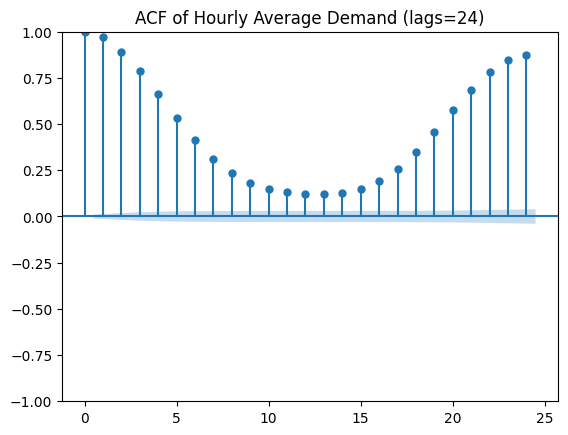

In [26]:
plot_acf(df['demand'].resample('H').mean().dropna(), lags=24)
plt.title('ACF of Hourly Average Demand (lags=24)')
plt.savefig('./data/output/acf_hr_lag24.png', dpi=300)
plt.show()

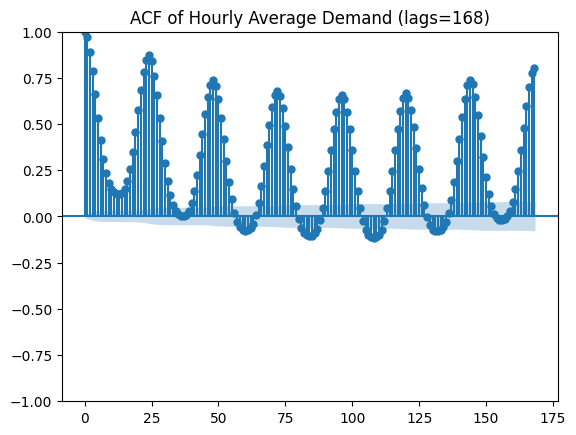

In [27]:
plot_acf(df['demand'].resample('H').mean().dropna(), lags=168)
plt.title('ACF of Hourly Average Demand (lags=168)')
plt.savefig('./data/output/acf_hr_lag168.png', dpi=300)
plt.show()

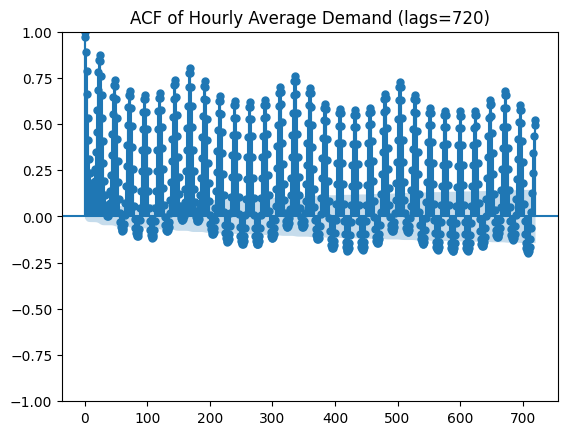

In [28]:
plot_acf(df['demand'].resample('H').mean().dropna(), lags=720)
plt.title('ACF of Hourly Average Demand (lags=720)')
plt.savefig('./data/output/acf_hr_lag720.png', dpi=300)
plt.show()

#### PACF

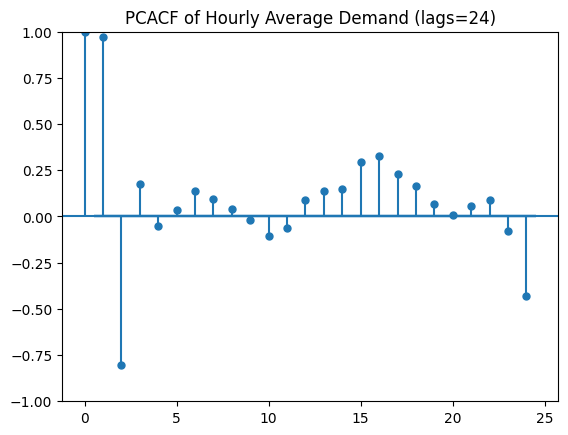

In [29]:
plot_pacf(df['demand'].resample('H').mean().dropna(), lags=24)
plt.title('PCACF of Hourly Average Demand (lags=24)')
plt.savefig('./data/output/pacf_hr_lag24.png', dpi=300)
plt.show()

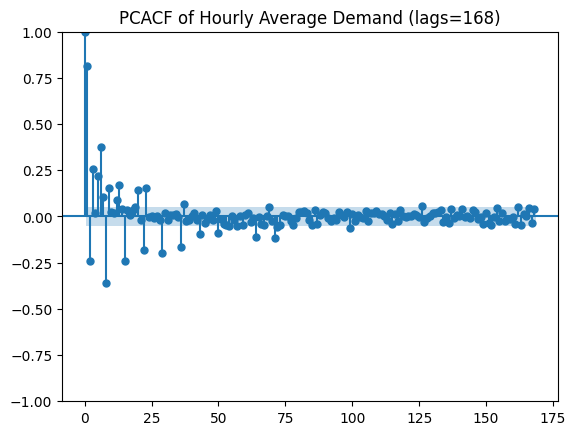

In [30]:
plot_pacf(df['demand'].resample('D').mean().dropna(), lags=168)
plt.title('PCACF of Hourly Average Demand (lags=168)')
plt.savefig('./data/output/pacf_hr_lag168.png', dpi=300)
plt.show()

In [31]:
# plot_pacf(df['demand'].resample('D').mean().dropna(), lags=720)
# plt.title('PCACF of Hourly Average Demand (lags=720)')
# plt.savefig('./data/output/pacf_hr_lag720.png', dpi=300)
# plt.show()

# Training

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32904 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  32904 non-null  float64
dtypes: float64(1)
memory usage: 514.1 KB


## Generic Functions

### Evaluation

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_forecast(y_true, y_pred,model_name=None,plot=True,train=None, test=None,forecast_mean=None, pred_ci=None,fold=None):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- Evaluation Results {f'for {model_name}' if model_name else ''} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    if plot:
        if all(v is not None for v in [forecast_mean, pred_ci]):
            plt.figure(figsize=(12, 5))

            plt.plot(test.index, test.values, label='Observed', color='black')
            plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='orange')
            plt.fill_between(
                pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],
                color='gray', alpha=0.3, label='95% CI'
            )

            title = f"{model_name} Forecast vs Observed"
            if fold is not None:
                title += f" (Fold {fold})"
            plt.title(title)
            plt.xlabel("Time")
            plt.ylabel("Demand")
            plt.legend(loc='upper left')
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 5))
            plt.plot(y_true, label='Actual', color='blue')
            plt.plot(y_pred, label='Predicted', color='orange')
            plt.title(f"Actual vs Predicted {f'({model_name})' if model_name else ''}")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return { "rmse": rmse,"mae": mae,"mape": mape,"r2": r2}


### Plot Split

In [34]:
from matplotlib.lines import Line2D
import matplotlib.cm as cm

def plot_splits(df, splits, strategy_name="Split Strategy"):
    cmap = cm.get_cmap('tab10', 2)  
    
    for i, (train, test) in enumerate(splits):
        plt.figure(figsize=(12, 4))
        
        plt.plot(df.index, df.values, color='lightgray', alpha=0.5)
        
        plt.plot(train.index, train.values, color=cmap(0), lw=1.5)
        
        plt.plot(test.index, test.values, color=cmap(1), lw=2, linestyle='--')
    
        legend_elements = [
            Line2D([0], [0], color='lightgray', lw=1.5, label='Full Series'),
            Line2D([0], [0], color=cmap(0), lw=1.5, label='Train'),
            Line2D([0], [0], color=cmap(1), lw=2, linestyle='--', label='Test')
        ]
        plt.legend(handles=legend_elements)
        
        plt.title(f"{strategy_name} - Fold {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.tight_layout()
        plt.show()


## Split

### Expanding Window

the idea of expanding set is we sequentially train and evaluate the model on more and more data  - this could help us determine how much training data we need or even help us breakdown the training task by snapshotting, evaluating and then adding on more data as we go or in the future

Fold 1: Train [1998-04-01 01:00:00–1998-07-30 00:00:00] (2880), Test [1998-07-30 01:00:00–1998-10-28 00:00:00] (2160)
Fold 2: Train [1998-04-01 01:00:00–1998-11-27 00:00:00] (5760), Test [1998-11-27 01:00:00–1999-02-25 00:00:00] (2160)
Fold 3: Train [1998-04-01 01:00:00–1999-03-27 00:00:00] (8640), Test [1999-03-27 01:00:00–1999-06-25 00:00:00] (2160)
Fold 4: Train [1998-04-01 01:00:00–1999-07-25 00:00:00] (11520), Test [1999-07-25 01:00:00–1999-10-23 00:00:00] (2160)
Fold 5: Train [1998-04-01 01:00:00–1999-11-22 00:00:00] (14400), Test [1999-11-22 01:00:00–2000-02-20 00:00:00] (2160)
Fold 6: Train [1998-04-01 01:00:00–2000-03-21 00:00:00] (17280), Test [2000-03-21 01:00:00–2000-06-19 00:00:00] (2160)
Fold 7: Train [1998-04-01 01:00:00–2000-07-19 00:00:00] (20160), Test [2000-07-19 01:00:00–2000-10-17 00:00:00] (2160)
Fold 8: Train [1998-04-01 01:00:00–2000-11-16 00:00:00] (23040), Test [2000-11-16 01:00:00–2001-02-14 00:00:00] (2160)
Fold 9: Train [1998-04-01 01:00:00–2001-03-16 00:00

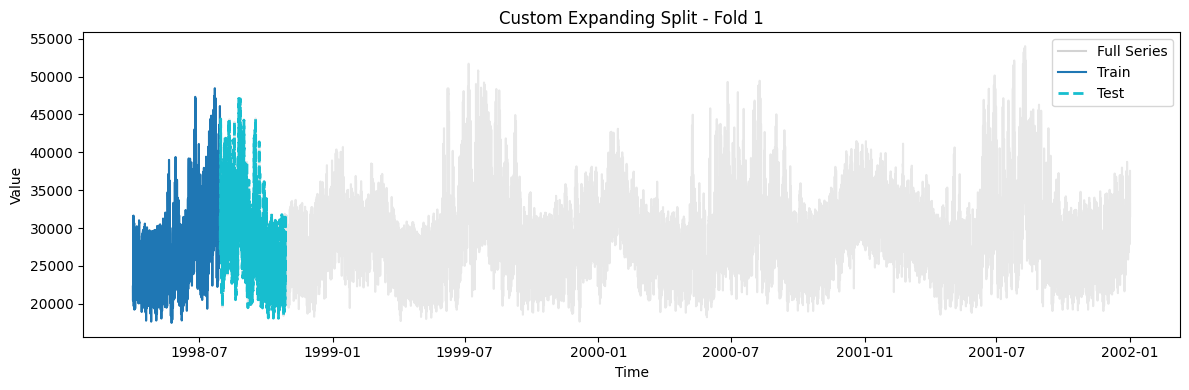

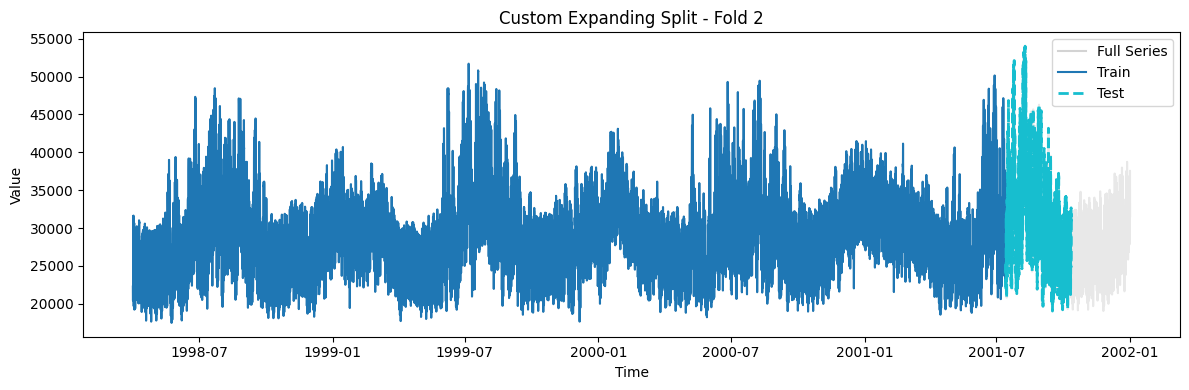

In [35]:
def get_custom_expanding_splits(df, initial_train_size=24*30,test_size=24*7,max_train_size=None,step_size=24*7):           
    splits = []
    start = 0
    while True:
        end_train = start + initial_train_size
        end_test = end_train + test_size
        if end_test > len(df):
            break

        train = df.iloc[start:end_train]
        test = df.iloc[end_train:end_test]

        splits.append((train, test))
        print(f"Fold {len(splits)}: Train [{train.index[0]}–{train.index[-1]}] ({len(train)}), "
              f"Test [{test.index[0]}–{test.index[-1]}] ({len(test)})")

        if max_train_size is None:
            initial_train_size += step_size
        else:
            initial_train_size = min(initial_train_size + step_size, max_train_size)

    return splits


custom_expanding_window_splits = get_custom_expanding_splits(df, initial_train_size=24*120, test_size=24*90, max_train_size=24*365*4, step_size=24*120)
custom_expanding_window_splits_selected = [custom_expanding_window_splits[0], custom_expanding_window_splits[-1]]
plot_splits(df['demand'], custom_expanding_window_splits_selected, strategy_name="Custom Expanding Split")

Here we select just two splits first and last - for readability and less clutter down the notebook

## Models

Usually I would just jump straight to XGBoost but for the sake of demonstration of why i usually skip these - we'll go step by step through the process

### ARIMA

ARIMA is a statistical model (AutoRegressive Integrated Moving Average)  
it takes params in terms of order (p,d,q) where  
  
p is the number of autoregressive steps  
d is the number of differences  
q is moving average  

p can be determined from PACF earlier which showed lag 1 to be very prominent, so we could use that  
  
q can be determined from ACF, which showed spikes around 1 and multiples of 7    
  
for d what we can do is do an ADF test - this will help us determine if the series is stationary (it has relatively constant mean and variance) - if not we will have to apply a sort of non seasonal differnce to nullify the effect of any trend and make the series appear stationary  

In [36]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['demand'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -13.213931387545598
p-value: 1.0336206543702723e-24


more negative indicates more stationary and p-value < 0.05 indicates confidence in the measurement  
so we know the series is stationary d=0  

we could choose to do a grid search between different ranges we've defined above  
or we could automatically find the best params by trying the code below for autoarima   

We end up just going with (1,0,1), (1,0,1,7) and (1,0,1,30) for daily 

In [37]:
from statsmodels.tsa.arima.model import ARIMA

def train_arima_on_splits(splits,order=(1,1,1),min_train_size=24*30, max_train_size=24*365):

    model_name = 'ARIMA'
    all_metrics = []

    for i, (train, test) in enumerate(splits):

        print(f"===== Fold {i+1} =====")
        # train = train.asfreq('H')
        # test = test.asfreq('H')
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        model = ARIMA(train['demand'], order=order)

        print(f"Training {model_name} model on fold {i+1} with order={order}")
        start_train = time.time()
        model_fit = model.fit()
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        model_fit.save(f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl')
        print(f"Fold {i+1} model saved to ./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl")

        print(model_fit.summary())
        model_fit.plot_diagnostics(figsize=(15, 12))
        
        start_infer = time.time()
        forecast_obj = model_fit.get_forecast(steps=len(test))
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")
        
        forecast_mean = forecast_obj.predicted_mean
        pred_ci = forecast_obj.conf_int()

        # valid_idx = (~np.isnan(test['demand'].values)) & (~np.isnan(forecast_mean.values))
        y_true_clean = test['demand'].values #[valid_idx]
        y_pred_clean = forecast_mean.values #[valid_idx]

        metrics = evaluate_forecast(
            y_true=y_true_clean,
            y_pred=y_pred_clean,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")
        
    return model_fit, all_metrics, avg_metrics

===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training ARIMA model on fold 1 with order=(1, 0, 1)
Training time: 2.89 seconds
Fold 1 model saved to ./data/output/models/ARIMA/ARIMA_fold_1.pkl
                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                 2880
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -24085.255
Date:                Thu, 31 Jul 2025   AIC                          48178.511
Time:                        11:24:48   BIC                          48202.373
Sample:                    04-01-1998   HQIC                         48187.112
                         - 07-30-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

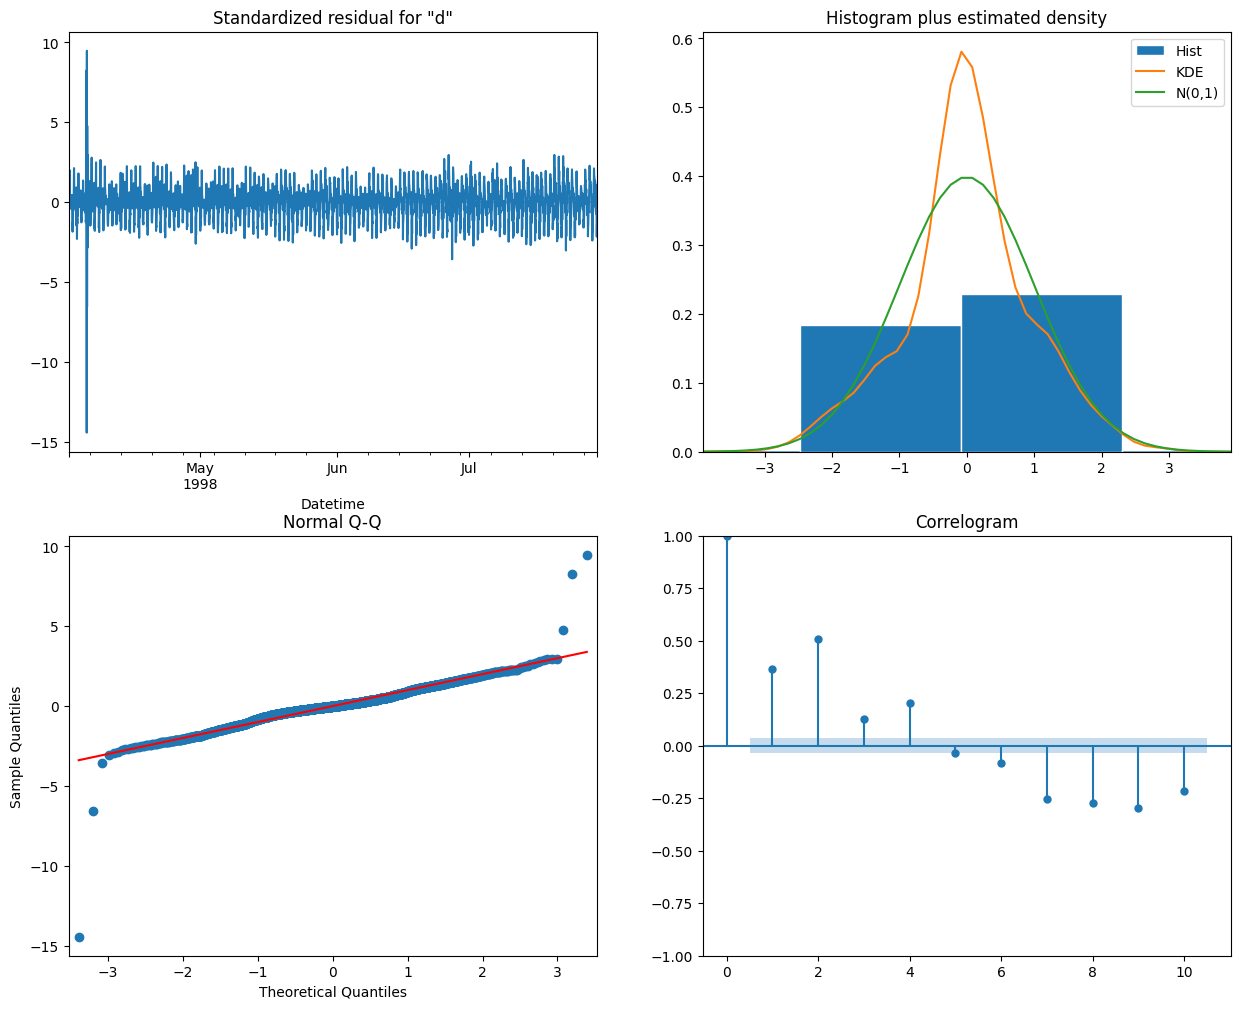

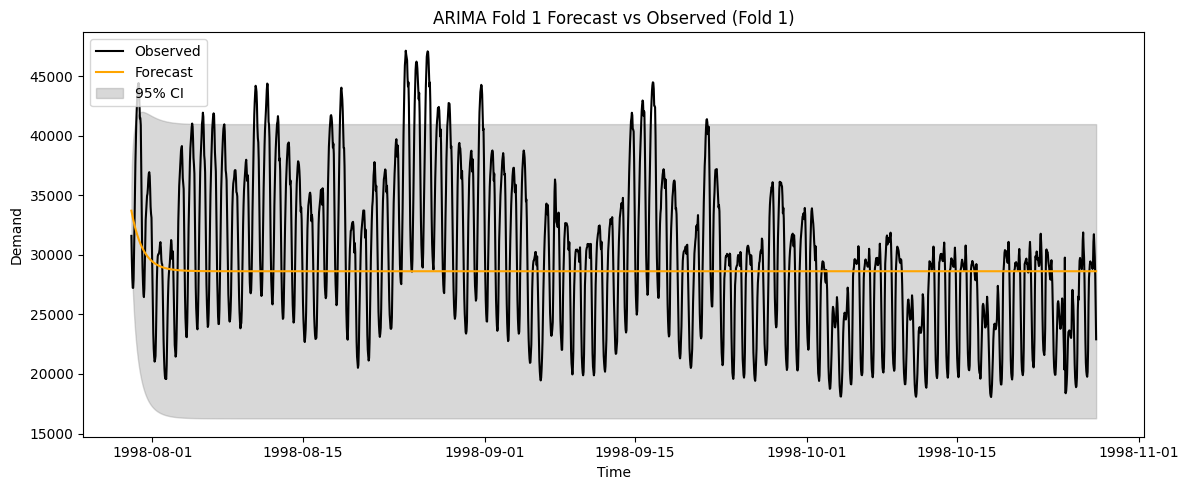

===== Fold 2 =====
Fold 2: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training ARIMA model on fold 2 with order=(1, 0, 1)
Training time: 10.80 seconds
Fold 2 model saved to ./data/output/models/ARIMA/ARIMA_fold_2.pkl
                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                 8760
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -72771.872
Date:                Thu, 31 Jul 2025   AIC                         145551.745
Time:                        11:25:02   BIC                         145580.056
Sample:                    07-14-2000   HQIC                        145561.391
                         - 07-14-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------

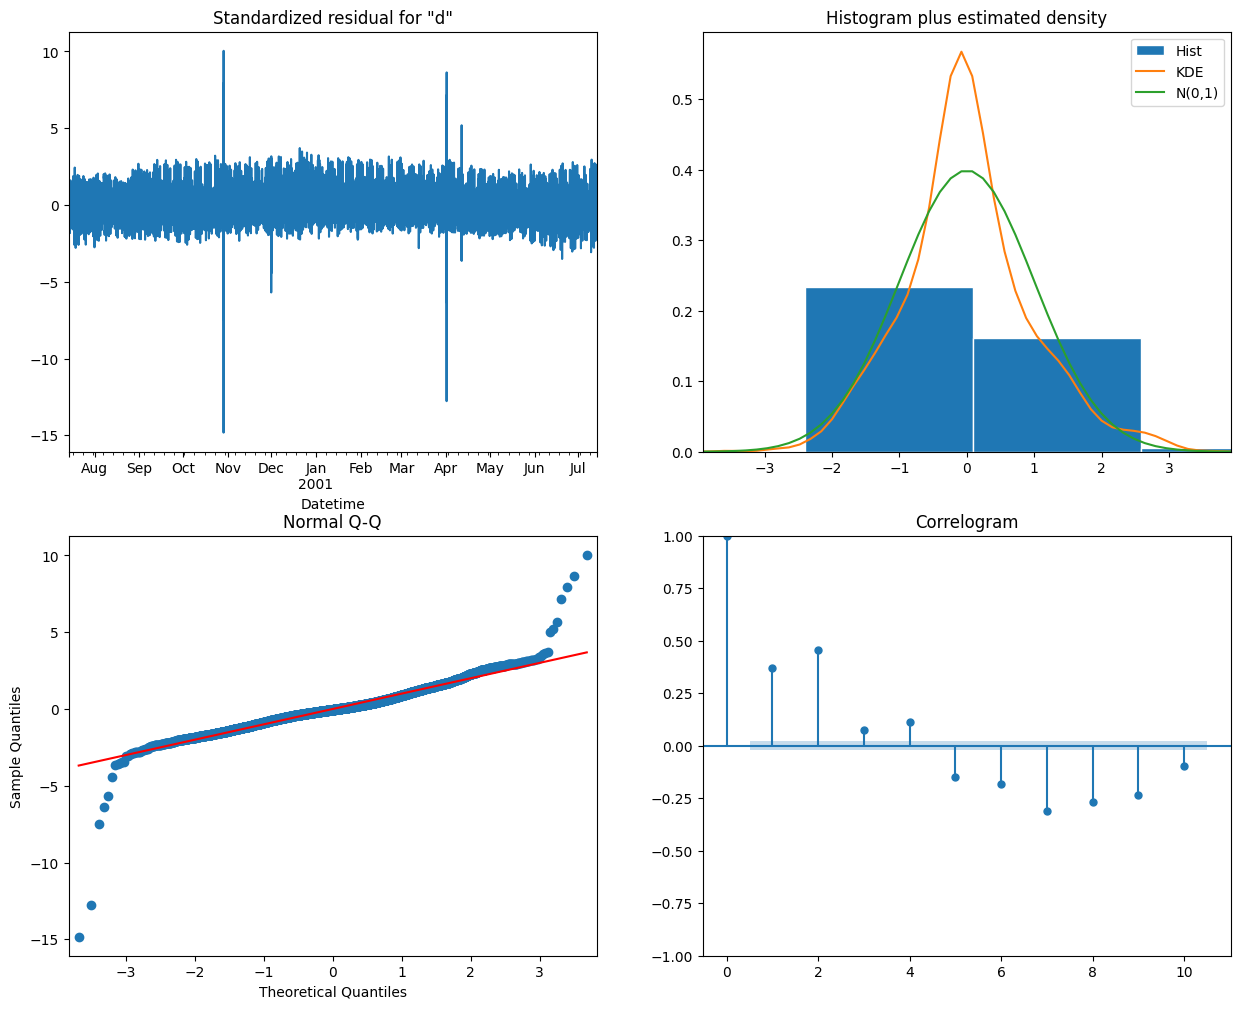

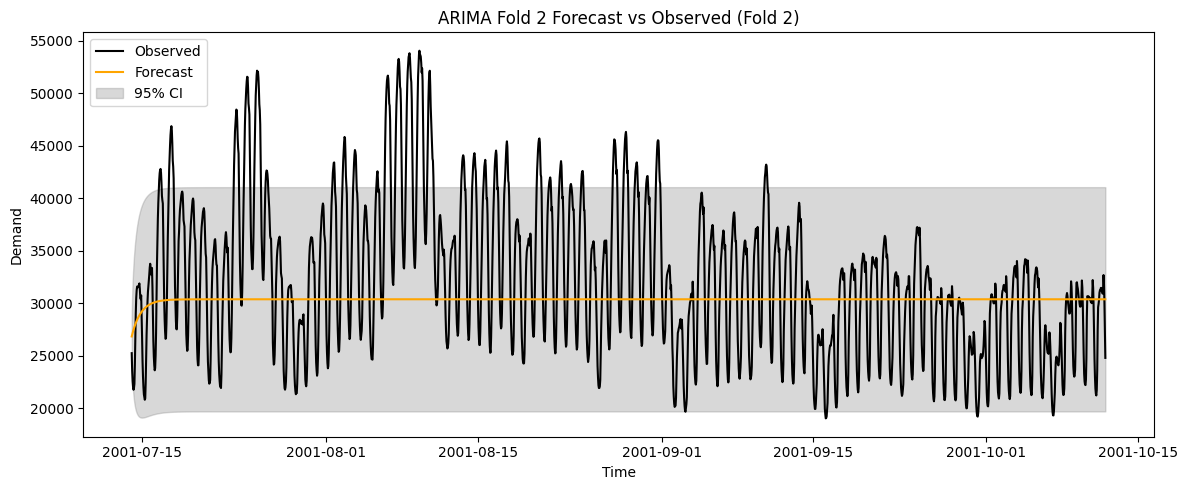


===== Average metrics across folds =====
RMSE: 7014.8578
MAE: 5545.7491
MAPE: 17.8139
R2: -0.0466


In [39]:
arima_model_fit, arima_all_metrics, arima_avg_metrics = train_arima_on_splits(
    splits= custom_expanding_window_splits_selected,
    order=(1,0,1),
    min_train_size=24*30,
    max_train_size=24*365
)


the constant term 3.036e+04 indictes sort of a base demand  
The ar.L1 0.95 means there is a strong correlation with the previous terms (0 would have meant almost no dependence and a negative number probably would have hinted at oscillations)  
The ma.L1 is 0.72 so there are some corrections being made for previous terms (0 would have meant well no adjustments were made)  
The sigma2 is quite high - error dispersion is quite high

'standardized residuals for d' should usually oscillate around 0, and even though this looks like it - as in there is no specific trend but there are a lot of spikes indicating either outliers (which can be bad or tolerable - susceptibility to miss extreme events)

the histogram displays the residuals are roughly centered around but are lightly more towards one side - i.e. not entirely gaussian distribution  
the q-q plot again shows the non normality in residuals espescially to the end where they deviate from the line  
then there is an ACF plot showing a lot of autocorrealation at lag 1


we know our data has seasonality but this model doesnt capture it

### SARIMA

(p,q,r,s)  
for seasonality s we notice a periodicity (weekly, monthly and even yearly!) so we can probably try s=7, s=30 or s=365 for daily data*   
here i changed it back to hourly so seasonality is accordingly 24 or 168 

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def train_sarima_on_splits(splits,order=(1,1,1),seasonal_order=(1,1,1,24),min_train_size=24*30, max_train_size=24*365):

    model_name = 'SARIMA'
    all_metrics = []

    for i, (train, test) in enumerate(splits):

        print(f"===== Fold {i+1} =====")
        # train = train.asfreq('H')
        # test = test.asfreq('H')
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]


        model = SARIMAX(
            train['demand'],
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        print(f"Training {model_name} model on fold {i+1} with order={order} and seasonal_order={seasonal_order}")
        start_train = time.time()
        model_fit = model.fit(disp=False)
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        model_fit.save(f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl')
        print(f"Fold {i+1} model saved to ./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl")

        print(model_fit.summary())
        model_fit.plot_diagnostics(figsize=(15, 12))
        
        start_infer = time.time()
        forecast_obj = model_fit.get_forecast(steps=len(test))
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")
        
        forecast_mean = forecast_obj.predicted_mean
        pred_ci = forecast_obj.conf_int()

        # valid_idx = (~np.isnan(test['demand'].values)) & (~np.isnan(forecast_mean.values))
        y_true_clean = test['demand'].values #[valid_idx]
        y_pred_clean = forecast_mean.values #[valid_idx]

        metrics = evaluate_forecast(
            y_true=y_true_clean,
            y_pred=y_pred_clean,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")
        
    return model_fit, all_metrics, avg_metrics


===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training SARIMA model on fold 1 with order=(1, 0, 1) and seasonal_order=(1, 0, 1, 24)
Training time: 28.86 seconds
Fold 1 model saved to ./data/output/models/SARIMA/SARIMA_fold_1.pkl
                                     SARIMAX Results                                      
Dep. Variable:                             demand   No. Observations:                 2880
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -22030.141
Date:                            Thu, 31 Jul 2025   AIC                          44070.281
Time:                                    11:25:38   BIC                          44100.063
Sample:                                04-01-1998   HQIC                         44081.021
                                     - 07-30-1998                                         
Covariance Type:                              opg                                         
                 coef    std e

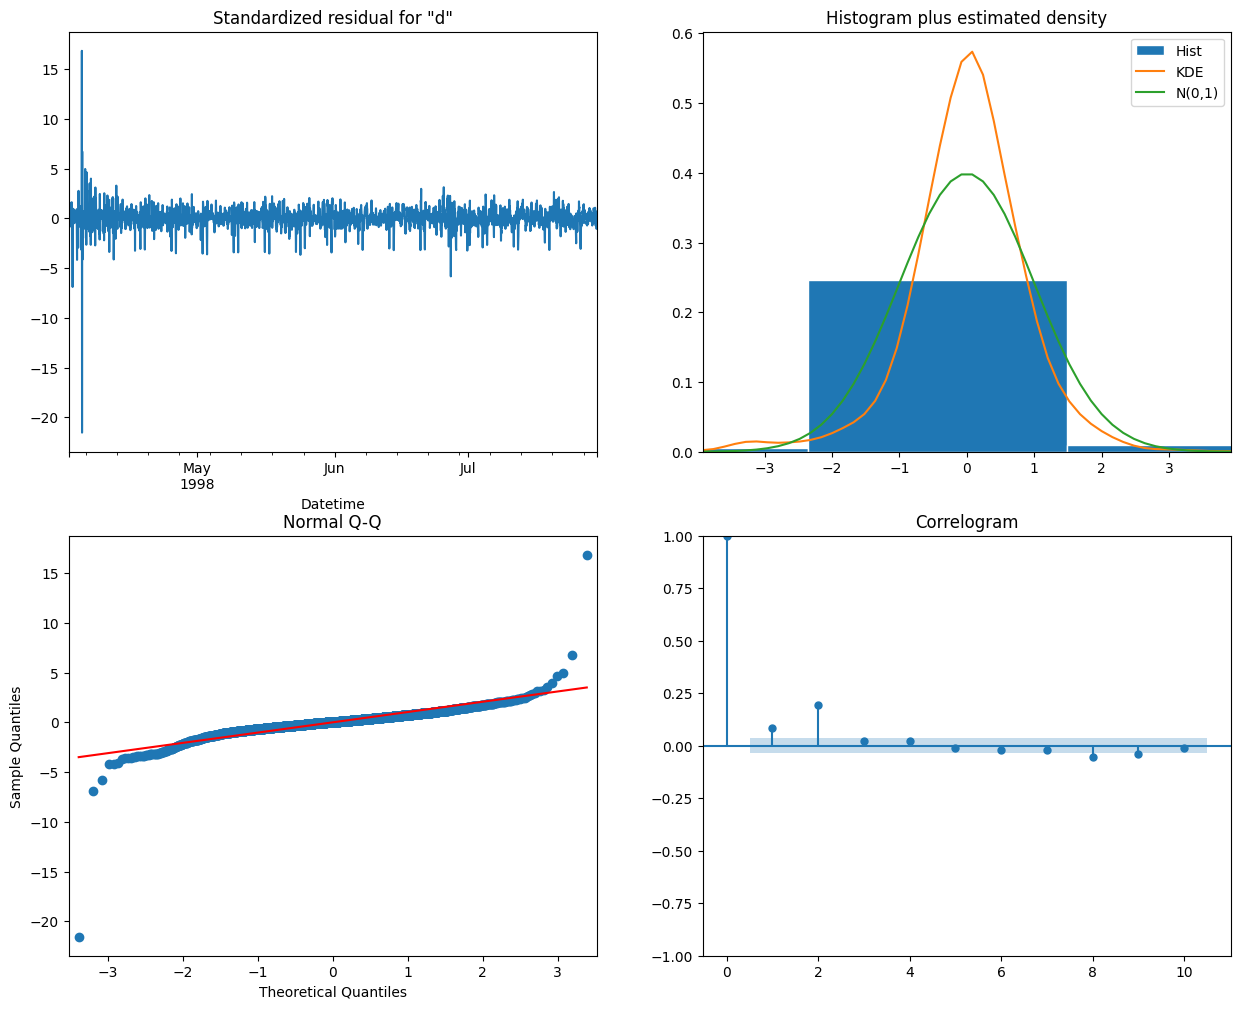

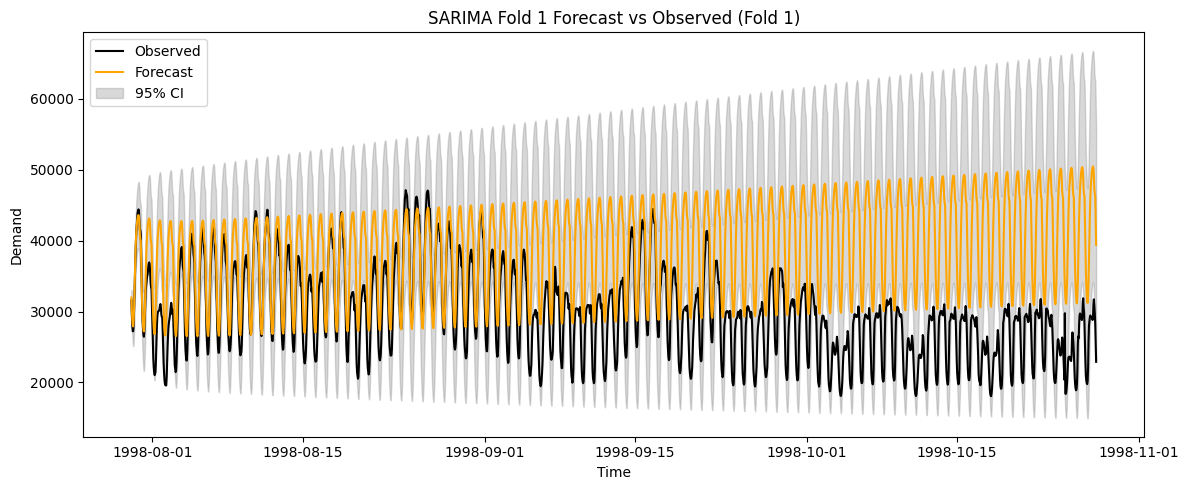

===== Fold 2 =====
Fold 2: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training SARIMA model on fold 2 with order=(1, 0, 1) and seasonal_order=(1, 0, 1, 24)
Training time: 64.33 seconds
Fold 2 model saved to ./data/output/models/SARIMA/SARIMA_fold_2.pkl
                                     SARIMAX Results                                      
Dep. Variable:                             demand   No. Observations:                 8760
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -66513.923
Date:                            Thu, 31 Jul 2025   AIC                         133037.846
Time:                                    11:26:54   BIC                         133073.221
Sample:                                07-14-2000   HQIC                        133049.902
                                     - 07-14-2001                                         
Covariance Type:                              opg                               

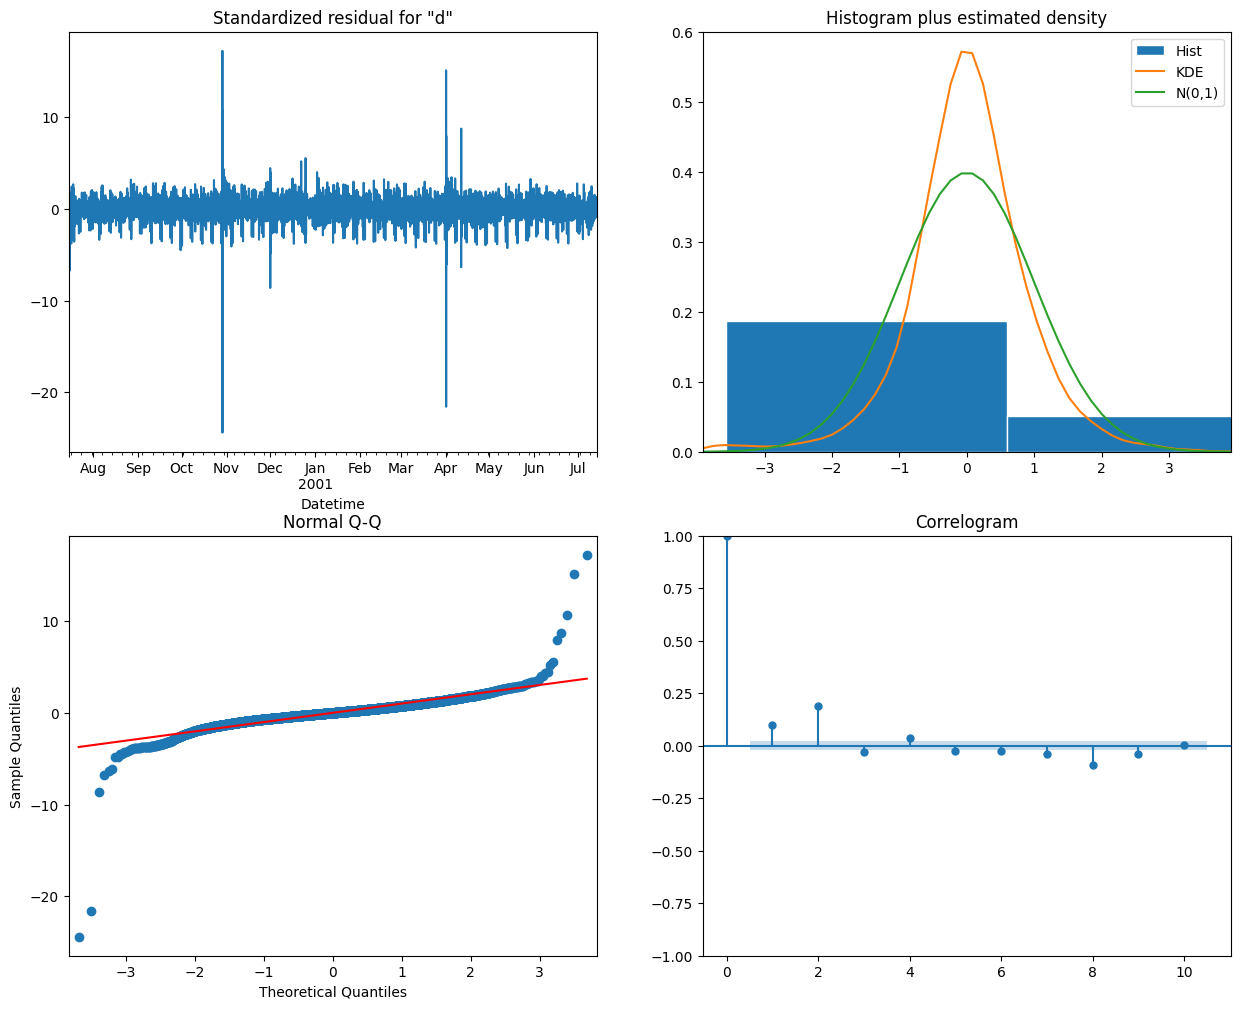

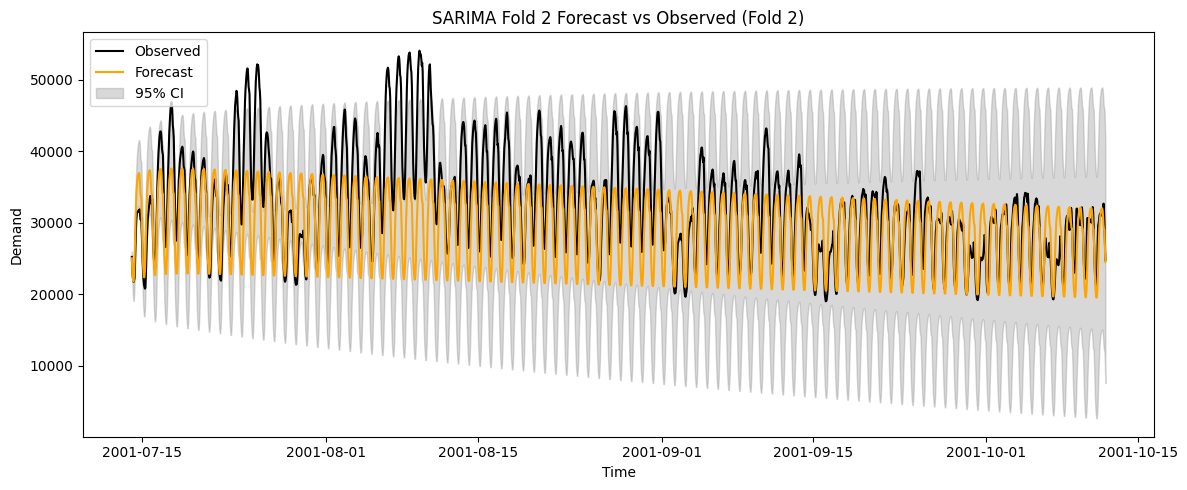


===== Average metrics across folds =====
RMSE: 8400.0351
MAE: 6780.6477
MAPE: 23.3077
R2: -0.8161


In [41]:
sarima_model_fit, sarima_all_metrics, sarima_avg_metrics = train_sarima_on_splits(
    splits= custom_expanding_window_splits_selected,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    min_train_size=24*30,
    max_train_size=24*365
)


### Holt Winters

Holt winters is a statistical time series model which adds sort of an exponential decay with time - make the recent features count more and older features count less  
its good for basic seasonality and short term trends 


In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def train_hw_on_splits(splits, seasonal='add', seasonal_periods=24, min_train_size=24*30, max_train_size=24*365):
    
    model_name = 'HoltWinters'
    all_metrics = []

    for i, (train, test) in enumerate(splits):

        print(f"===== Fold {i+1} =====")
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365)

        print(f"Training {model_name} model on fold {i+1}")
        start_train = time.time()
        model_fit = model.fit()
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        model_fit.save(f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl')
        print(f"Fold {i+1} model saved to ./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl")

        # print(model_fit.summary())
        # model_fit.plot_diagnostics(figsize=(15, 12))
        summary_str = str(model_fit.summary())
        lines = summary_str.split("\n")
        for i, line in enumerate(lines):
            if i < 40:
                print(line)
            else:
                print(f"... (output truncated, total {len(lines)} lines) ...")
                break
        
        start_infer = time.time()
        forecast_mean = model_fit.forecast(steps=len(test))
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")

        forecast_index = test.index 
        forecast_mean = pd.Series(forecast_mean, index=forecast_index)
        resid_std = np.std(model_fit.resid)
        pred_ci = pd.DataFrame({
            'lower': forecast_mean - 1.96 * resid_std,
            'upper': forecast_mean + 1.96 * resid_std
        }, index=forecast_index)


        y_true_clean = test['demand'].values 
        y_pred_clean = forecast_mean.values 

        metrics = evaluate_forecast(
            y_true=y_true_clean,
            y_pred=y_pred_clean,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")
        
    return model_fit, all_metrics, avg_metrics


===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training HoltWinters model on fold 1
Training time: 1.86 seconds
Fold 1 model saved to ./data/output/models/HoltWinters/HoltWinters_fold_1.pkl
                       ExponentialSmoothing Model Results                       
Dep. Variable:                   demand   No. Observations:                 2880
Model:             ExponentialSmoothing   SSE                     5983391840.989
Optimized:                         True   AIC                          42628.519
Trend:                             None   BIC                          44817.874
Seasonal:                      Additive   AICC                         42737.308
Seasonal Periods:                   365   Date:                 Thu, 31 Jul 2025
Box-Cox:                          False   Time:                         14:28:00
Box-Cox Coeff.:                    None                                         
                           coeff                 code              op

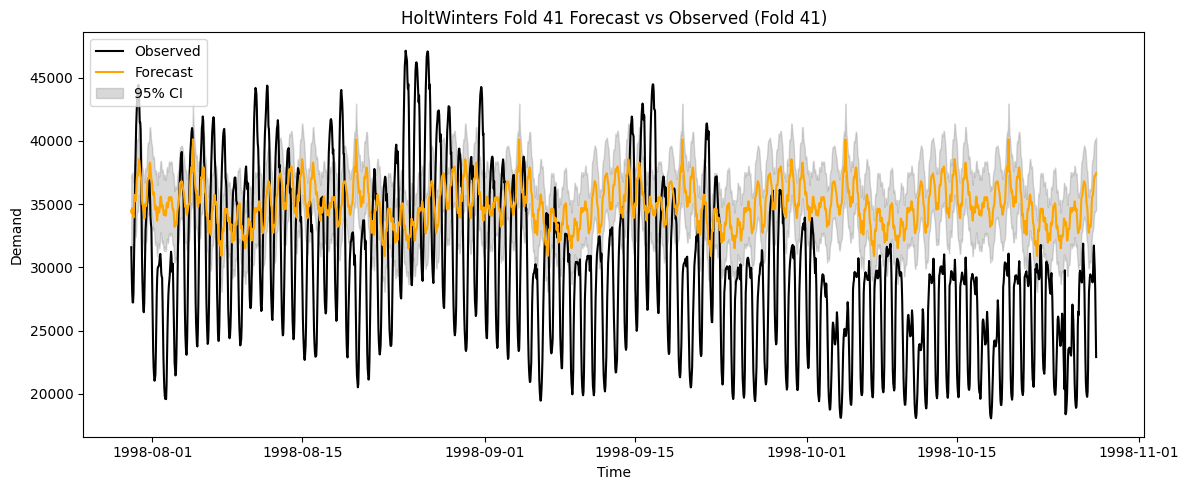

===== Fold 2 =====
Fold 2: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training HoltWinters model on fold 2
Training time: 1.03 seconds
Fold 2 model saved to ./data/output/models/HoltWinters/HoltWinters_fold_2.pkl
                       ExponentialSmoothing Model Results                       
Dep. Variable:                   demand   No. Observations:                 8760
Model:             ExponentialSmoothing   SSE                    18711302544.634
Optimized:                         True   AIC                         128406.115
Trend:                             None   BIC                         131003.724
Seasonal:                      Additive   AICC                        128438.661
Seasonal Periods:                   365   Date:                 Thu, 31 Jul 2025
Box-Cox:                          False   Time:                         14:28:03
Box-Cox Coeff.:                    None                                         
                           c

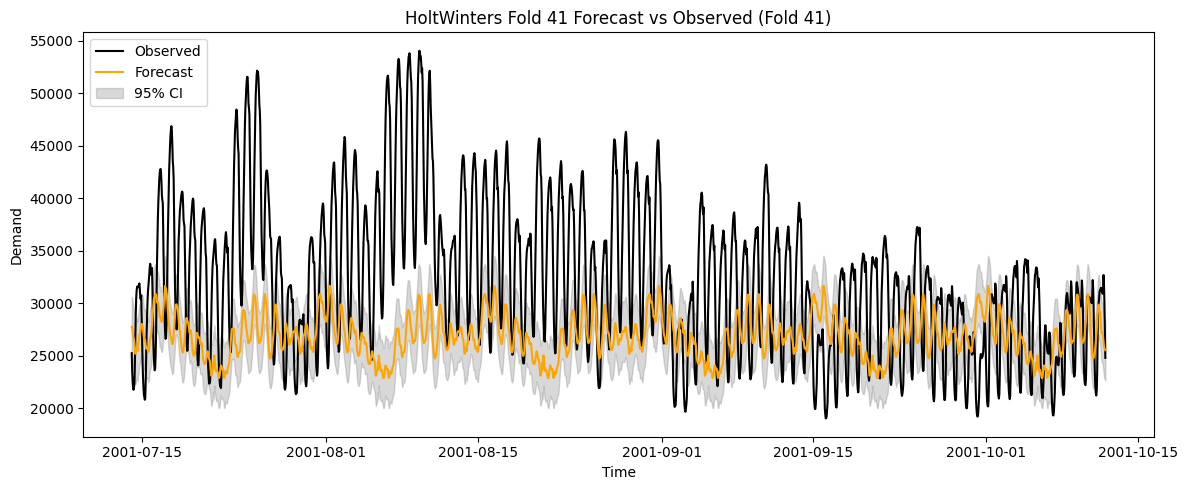


===== Average metrics across folds =====
RMSE: 8809.8129
MAE: 7199.8602
MAPE: 24.1377
R2: -0.6559


In [47]:
hw_model, hw_all_metrics, hw_avg_metrics = train_hw_on_splits(
    splits= custom_expanding_window_splits_selected,
    seasonal='add',
    seasonal_periods=365,
    min_train_size=24*30,
    max_train_size=24*365
)

### Prophet

In [44]:
from prophet import Prophet

def train_prophet_on_splits(splits, min_train_size=24*30, max_train_size=24*365, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False):
    
    model_name = 'Prophet'
    all_metrics = []

    for i, (train, test) in enumerate(splits):

        print(f"===== Fold {i+1} =====")
        print(f"Fold {i+1}: train size={len(train)}, test size={len(test)}")

        if len(train) < min_train_size:
            print(f"Skipping fold {i+1}: train size too small ({len(train)} < {min_train_size})")
            continue
        elif len(train) > max_train_size:
            print(f"Reducing train size to max {max_train_size} samples")
            train = train.iloc[-max_train_size:]

        prophet_train_data = pd.DataFrame({'ds': train.index, 'y': train['demand'].values})
        prophet_test_data = pd.DataFrame({'ds': test.index})

        print(f"Training {model_name} model on fold {i+1}")
        model = Prophet(
            daily_seasonality=daily_seasonality, 
            weekly_seasonality=weekly_seasonality,
            yearly_seasonality=yearly_seasonality
        )

        print(f"Training {model_name} model on fold {i+1}")
        start_train = time.time()
        model_fit = model.fit(prophet_train_data)
        end_train = time.time()
        print(f"Training time: {end_train - start_train:.2f} seconds")

        with open(f'./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl', 'wb') as f:
            pickle.dump(model_fit, f)
        print(f"Fold {i+1} model saved to ./data/output/models/{model_name}/{model_name}_fold_{i+1}.pkl")

        # print(model_fit.params)
        # model_fit.plot_components(prophet_train_data)
        
        start_infer = time.time()
        forecast_df = model_fit.predict(prophet_test_data)
        end_infer = time.time()
        print(f"Inference time: {end_infer - start_infer:.2f} seconds")

        forecast_mean = forecast_df[['ds', 'yhat']].set_index('ds')['yhat']
        pred_ci = forecast_df.set_index('ds')[['yhat_lower', 'yhat_upper']]

        y_true_clean = test['demand'].values 
        y_pred_clean = forecast_mean.values 

        metrics = evaluate_forecast(
            y_true=y_true_clean,
            y_pred=y_pred_clean,
            model_name=f"{model_name} Fold {i+1}",
            plot=True, train=train, test=test,
            forecast_mean=forecast_mean, pred_ci=pred_ci, fold=i+1
        )
        all_metrics.append(metrics)

    avg_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
    print("\n===== Average metrics across folds =====")
    for k, v in avg_metrics.items():
        print(f"{k.upper()}: {v:.4f}")
        
    return model_fit, all_metrics, avg_metrics


Importing plotly failed. Interactive plots will not work.


===== Fold 1 =====
Fold 1: train size=2880, test size=2160
Training Prophet model on fold 1
Training Prophet model on fold 1


11:27:05 - cmdstanpy - INFO - Chain [1] start processing
11:27:08 - cmdstanpy - INFO - Chain [1] done processing


Training time: 4.15 seconds
Fold 1 model saved to ./data/output/models/Prophet/Prophet_fold_1.pkl
Inference time: 1.12 seconds

--- Evaluation Results for Prophet Fold 1 ---
RMSE: 22688.0475
MAE: 19953.2294
MAPE: 74.45%
R²: -11.6868


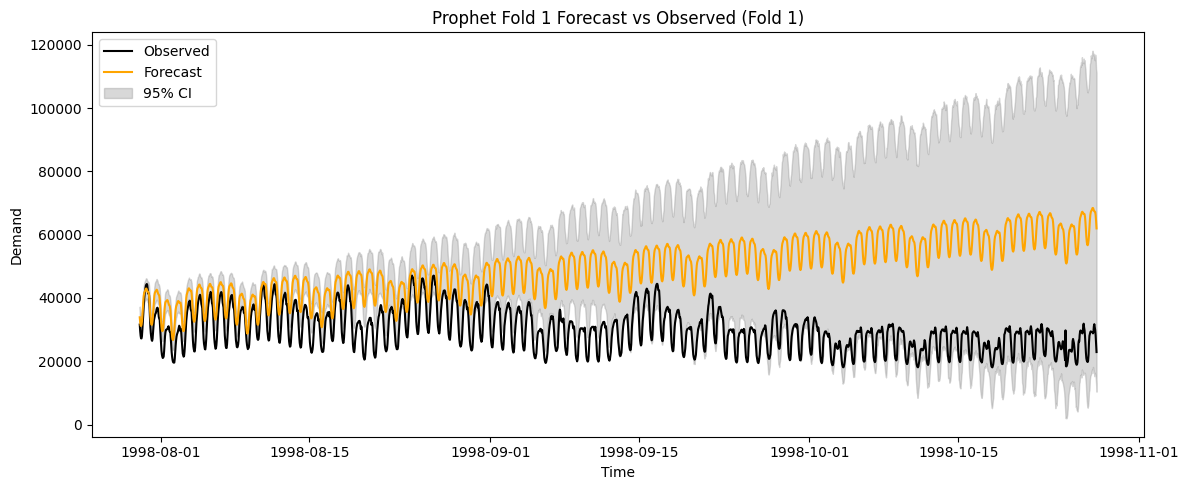

===== Fold 2 =====
Fold 2: train size=28800, test size=2160
Reducing train size to max 8760 samples
Training Prophet model on fold 2
Training Prophet model on fold 2


11:27:11 - cmdstanpy - INFO - Chain [1] start processing
11:27:21 - cmdstanpy - INFO - Chain [1] done processing


Training time: 10.85 seconds
Fold 2 model saved to ./data/output/models/Prophet/Prophet_fold_2.pkl
Inference time: 1.01 seconds

--- Evaluation Results for Prophet Fold 2 ---
RMSE: 10251.7788
MAE: 8554.9698
MAPE: 30.07%
R²: -0.9535


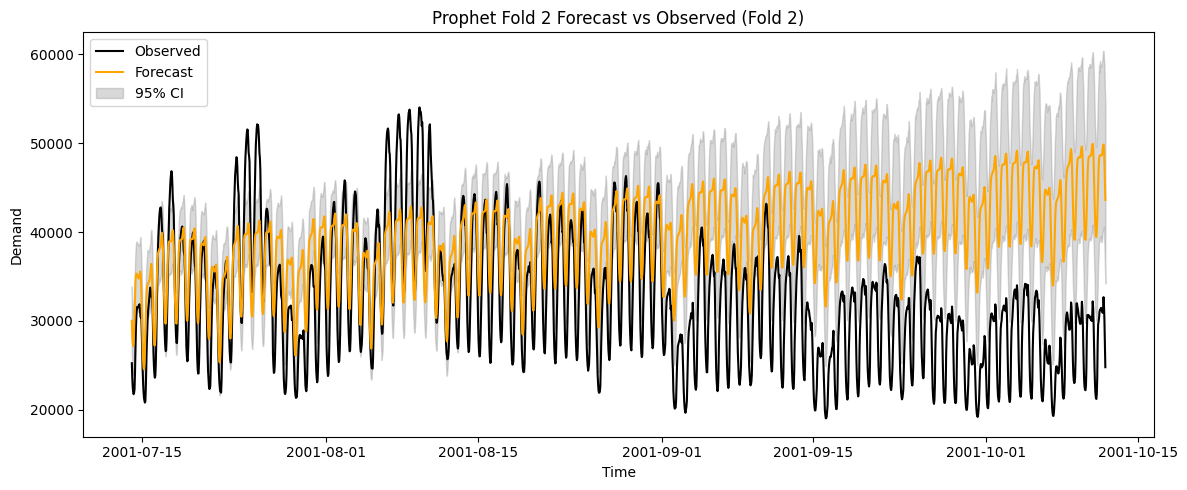


===== Average metrics across folds =====
RMSE: 16469.9131
MAE: 14254.0996
MAPE: 52.2592
R2: -6.3201


In [45]:
prophet_model_fit, prophet_all_metrics, prophet_avg_metrics = train_prophet_on_splits(
    splits= custom_expanding_window_splits_selected, 
    daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False,
    min_train_size=24*30, max_train_size=24*365
)